## Vision Transformer (Pre - Trained)

In [1]:
# ViT-ResNet - Pre-trained Vision Transformer using timm library
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import timm

from torch.optim import AdamW
from sklearn.metrics import roc_auc_score, roc_curve, auc
from itertools import cycle
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

In [2]:
# Run data.ipynb to get data loaders
%run data.ipynb

Data root: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Total Trainable Data:  112120
Training set size:  60
Validation set size:  20
Test set size:  20
Images path: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Training batches: 2
Validation batches: 1
Test batches: 1


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
# Hyperparameters
num_classes = len(parser.labels)
batch_size = 16
learning_rate = 1e-4
num_epochs = 10

print(f"Number of classes: {num_classes}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {num_epochs}")

Number of classes: 15
Batch size: 16
Learning rate: 0.0001
Epochs: 10


In [5]:
# Create Pre-trained ViT model using timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify classification head for our task
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: vit_base_patch16_224 (pretrained)")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model: vit_base_patch16_224 (pretrained)
Total parameters: 85,810,191
Trainable parameters: 85,810,191


In [6]:
# Training function with AUC fix
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, save_path='files/vit_pretrained_best.pth'):
    """Train pre-trained ViT model"""
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_auc': [], 'val_auc': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        all_train_targets = []
        all_train_outputs = []
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.numel()
            
            all_train_targets.append(labels.cpu().numpy())
            all_train_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())
            
            train_pbar.set_postfix({'loss': loss.item()})
        
        # Calculate training metrics
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_correct / train_total * 100
        
        # AUC calculation with valid classes check
        all_train_targets = np.vstack(all_train_targets)
        all_train_outputs = np.vstack(all_train_outputs)
        try:
            valid_classes = [i for i in range(all_train_targets.shape[1]) 
                           if len(np.unique(all_train_targets[:, i])) > 1]
            if len(valid_classes) > 0:
                epoch_train_auc = roc_auc_score(
                    all_train_targets[:, valid_classes],
                    all_train_outputs[:, valid_classes],
                    average='macro'
                )
            else:
                epoch_train_auc = 0.0
        except ValueError:
            epoch_train_auc = 0.0
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['train_auc'].append(epoch_train_auc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_targets = []
        all_val_outputs = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()
                
                all_val_targets.append(labels.cpu().numpy())
                all_val_outputs.append(torch.sigmoid(outputs).cpu().numpy())
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total * 100
        
        all_val_targets = np.vstack(all_val_targets)
        all_val_outputs = np.vstack(all_val_outputs)
        try:
            valid_classes = [i for i in range(all_val_targets.shape[1]) 
                           if len(np.unique(all_val_targets[:, i])) > 1]
            if len(valid_classes) > 0:
                epoch_val_auc = roc_auc_score(
                    all_val_targets[:, valid_classes],
                    all_val_outputs[:, valid_classes],
                    average='macro'
                )
            else:
                epoch_val_auc = 0.0
        except ValueError:
            epoch_val_auc = 0.0
        
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_auc'].append(epoch_val_auc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%, AUC: {epoch_train_auc:.4f}')
        print(f'  Val   - Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%, AUC: {epoch_val_auc:.4f}')
        
        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            print(f'  >> Saved best model with val_loss: {best_val_loss:.4f}')
    
    return history

print("Training function defined")

Training function defined


In [7]:
# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/10:
  Train - Loss: 0.6665, Acc: 61.11%, AUC: 0.4618
  Val   - Loss: 0.3667, Acc: 87.00%, AUC: 0.3512
  >> Saved best model with val_loss: 0.3667


Epoch 2/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/10:
  Train - Loss: 0.3027, Acc: 89.00%, AUC: 0.5019
  Val   - Loss: 0.3418, Acc: 86.67%, AUC: 0.5857
  >> Saved best model with val_loss: 0.3418


Epoch 3/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/10:
  Train - Loss: 0.2897, Acc: 88.44%, AUC: 0.6666
  Val   - Loss: 0.3443, Acc: 85.67%, AUC: 0.6675


Epoch 4/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/10:
  Train - Loss: 0.2830, Acc: 88.67%, AUC: 0.6748
  Val   - Loss: 0.3326, Acc: 87.00%, AUC: 0.6836
  >> Saved best model with val_loss: 0.3326


Epoch 5/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/10:
  Train - Loss: 0.2834, Acc: 89.00%, AUC: 0.6673
  Val   - Loss: 0.3163, Acc: 87.00%, AUC: 0.6713
  >> Saved best model with val_loss: 0.3163


Epoch 6/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/10:
  Train - Loss: 0.2755, Acc: 89.33%, AUC: 0.7197
  Val   - Loss: 0.3345, Acc: 86.00%, AUC: 0.6422


Epoch 7/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/10:
  Train - Loss: 0.2672, Acc: 89.78%, AUC: 0.7977
  Val   - Loss: 0.3483, Acc: 85.33%, AUC: 0.6282


Epoch 8/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/10:
  Train - Loss: 0.2666, Acc: 89.33%, AUC: 0.7465
  Val   - Loss: 0.3328, Acc: 87.00%, AUC: 0.6541


Epoch 9/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/10:
  Train - Loss: 0.2576, Acc: 90.22%, AUC: 0.8327
  Val   - Loss: 0.3184, Acc: 87.33%, AUC: 0.6707


Epoch 10/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/10:
  Train - Loss: 0.2425, Acc: 90.22%, AUC: 0.8820
  Val   - Loss: 0.3232, Acc: 86.67%, AUC: 0.6673


In [8]:
# Evaluate on test set
def evaluate_model(model, test_loader, criterion):
    """Evaluate model on test set"""
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            test_correct += (preds == labels).sum().item()
            test_total += labels.numel()
            
            all_targets.append(labels.cpu().numpy())
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total * 100
    
    all_targets = np.vstack(all_targets)
    all_outputs = np.vstack(all_outputs)
    
    try:
        valid_classes = [i for i in range(all_targets.shape[1]) 
                       if len(np.unique(all_targets[:, i])) > 1]
        if len(valid_classes) > 0:
            test_auc = roc_auc_score(
                all_targets[:, valid_classes],
                all_outputs[:, valid_classes],
                average='macro'
            )
        else:
            test_auc = 0.0
    except ValueError:
        test_auc = 0.0
    
    print(f"\nTest Results (Pre-trained ViT):")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_acc:.2f}%")
    print(f"  AUC: {test_auc:.4f}")
    
    return test_loss, test_acc, test_auc

test_loss, test_acc, test_auc = evaluate_model(model, test_loader, criterion)

Testing:   0%|          | 0/1 [00:00<?, ?it/s]


Test Results (Pre-trained ViT):
  Loss: 0.3768
  Accuracy: 87.00%
  AUC: 0.6694


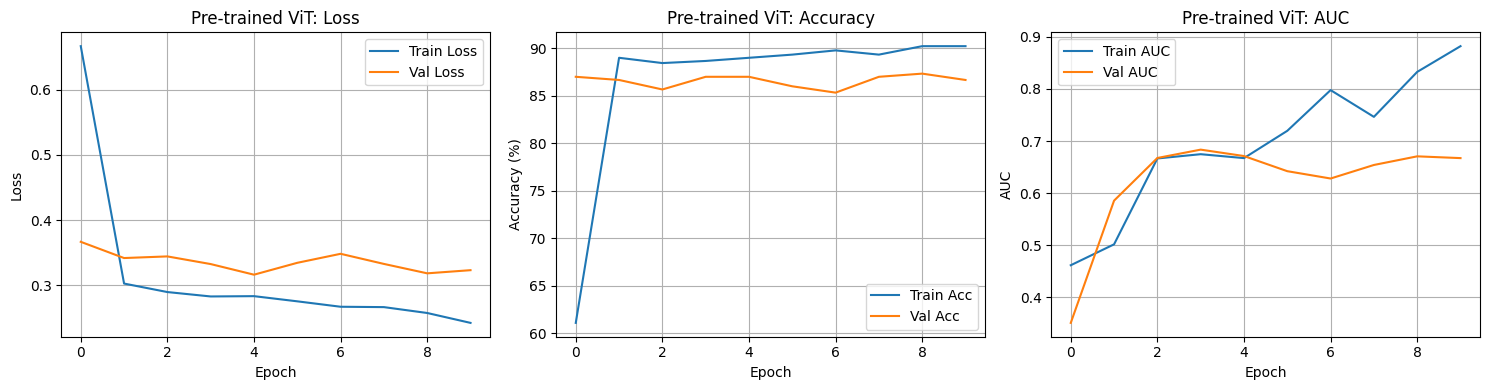

In [9]:
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Pre-trained ViT: Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Pre-trained ViT: Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # AUC
    axes[2].plot(history['train_auc'], label='Train AUC')
    axes[2].plot(history['val_auc'], label='Val AUC')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].set_title('Pre-trained ViT: AUC')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.savefig('files/vit_pretrained_training.png', dpi=150)
    plt.show()

plot_training_history(history)